**Table of contents**<a id='toc0_'></a>    
- [Pricing using Hagan's formula (provided)](#toc1_1_)    
    - [(1) SABR: $0<\beta\le 1$](#toc1_1_1_)    
    - [(2) SABR: $\beta=0$](#toc1_1_2_)    
    - [(3) Smile calibration to 3 options](#toc1_1_3_)    
  - [Pricing under MC method](#toc1_2_)    
  - [Pricing under conditional MC method](#toc1_3_)    
  - [Compare the MC variance between brute-force MC and conditional MC](#toc1_4_)    
    - [a.Comparison between ModelBsmMC and ModelBsmCondMC](#toc1_4_1_)    
    - [b.Comparison between ModelNormalMC and ModelNormalCondMC](#toc1_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import sabr
import random
import time
import pandas as pd

np.set_printoptions(precision=3)

## <a id='toc1_1_'></a>[Pricing using Hagan's formula (provided)](#toc0_)

### <a id='toc1_1_1_'></a>[(1) SABR: $0<\beta\le 1$](#toc0_)

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 1
vov = 0.5
rho = 0.25
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
# sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([0.204, 0.203, 0.202, 0.201, 0.2  , 0.2  , 0.2  , 0.2  , 0.201,
        0.202, 0.203, 0.204, 0.205, 0.206, 0.208, 0.21 , 0.211, 0.213,
        0.215, 0.217, 0.219, 0.221, 0.223, 0.225, 0.227]))

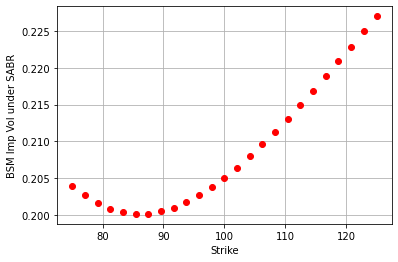

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### <a id='toc1_1_2_'></a>[(2) SABR: $\beta=0$](#toc0_)

In [7]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 1
alpha = 0.5
rho = -0.25

In [8]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

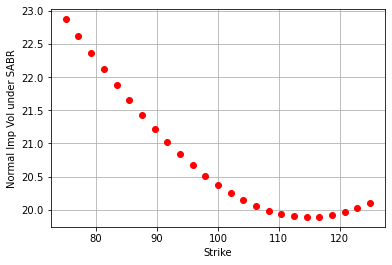

In [9]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### <a id='toc1_1_3_'></a>[(3) Smile calibration to 3 options](#toc0_)

In [10]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([13.608,  8.165,  4.769]), array([0.201, 0.205, 0.213]))

In [11]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': 0.25,
 'beta': 1}

In [12]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.2000000000001008,
 'vov': 0.49999999986727106,
 'rho': 0.2499999999825857}

In [13]:
# make sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.20000000000010157,
 'vov': 0.49999999986712995,
 'rho': 0.24999999998256023}

## <a id='toc1_2_'></a>[Pricing under MC method](#toc0_)

In [14]:
strike = np.linspace(75,125,num=25)
forward = 100

In [15]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [16]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.935, 24.042, 22.205, 20.429, 18.725, 17.106, 15.573, 14.132,
        12.78 , 11.52 , 10.357,  9.288,  8.314,  7.429,  6.625,  5.899,
         5.25 ,  4.668,  4.149,  3.693,  3.294,  2.937,  2.623,  2.347,
         2.105]))

Repeat the same for beta = 0

In [17]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [18]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.59 , 24.754, 22.959, 21.207, 19.504, 17.85 , 16.255, 14.729,
        13.276, 11.898, 10.598,  9.379,  8.246,  7.204,  6.256,  5.399,
         4.623,  3.935,  3.324,  2.787,  2.325,  1.928,  1.59 ,  1.3  ,
         1.054]))

## <a id='toc1_3_'></a>[Pricing under conditional MC method](#toc0_)

In [19]:
strike = np.linspace(75,125,num=25)
forward = 100

In [20]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [21]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([25.631, 23.751, 21.924, 20.159, 18.465, 16.85 , 15.32 , 13.884,
        12.543, 11.302, 10.159,  9.115,  8.165,  7.306,  6.532,  5.838,
         5.217,  4.663,  4.17 ,  3.731,  3.342,  2.996,  2.689,  2.417,
         2.175]),
 array([25.628, 23.751, 21.927, 20.164, 18.472, 16.859, 15.331, 13.896,
        12.556, 11.314, 10.17 ,  9.124,  8.172,  7.31 ,  6.533,  5.836,
         5.212,  4.654,  4.158,  3.716,  3.324,  2.976,  2.667,  2.393,
         2.149]))

Repeat the same for beta = 0

In [22]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


In [23]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)
    
# make sure the two prices are similar
price_hagan, price_mc

(array([26.591, 24.753, 22.952, 21.192, 19.479, 17.818, 16.215, 14.675,
        13.206, 11.811, 10.497,  9.268,  8.129,  7.08 ,  6.125,  5.262,
         4.49 ,  3.807,  3.207,  2.686,  2.237,  1.854,  1.53 ,  1.257,
         1.03 ]),
 array([26.208, 24.351, 22.534, 20.762, 19.043, 17.381, 15.784, 14.259,
        12.811, 11.446, 10.17 ,  8.984,  7.893,  6.896,  5.993,  5.182,
         4.459,  3.82 ,  3.259,  2.771,  2.348,  1.984,  1.672,  1.406,
         1.181]))

## <a id='toc1_4_'></a>[Compare the MC variance between brute-force MC and conditional MC](#toc0_)
For this, you should not use the random number seed

repeat 100 times and compare mean and dev

### <a id='toc1_4_1_'></a>[Comparison between ModelBsmMC and ModelBsmCondMC](#toc0_)

In [24]:
print(sabr_bsm.__dict__)
sabr_bsm_mc = sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
sabr_bsm_cmc = sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
strike = np.linspace(75,125,num=25)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': 0.25, 'beta': 1}


In [25]:
repeat = 100
len = strike.shape[0]
res1, res2 = np.ones((repeat, len)), np.ones((repeat, len))


for t in range(repeat):
    res1[t,:] = sabr_bsm_mc.price(strike, forward, texp)

for t in range(repeat):
    res2[t,:] = sabr_bsm_cmc.price(strike, forward, texp)
end2 = time.time()

NameError: name 'FormatStrFormatter' is not defined

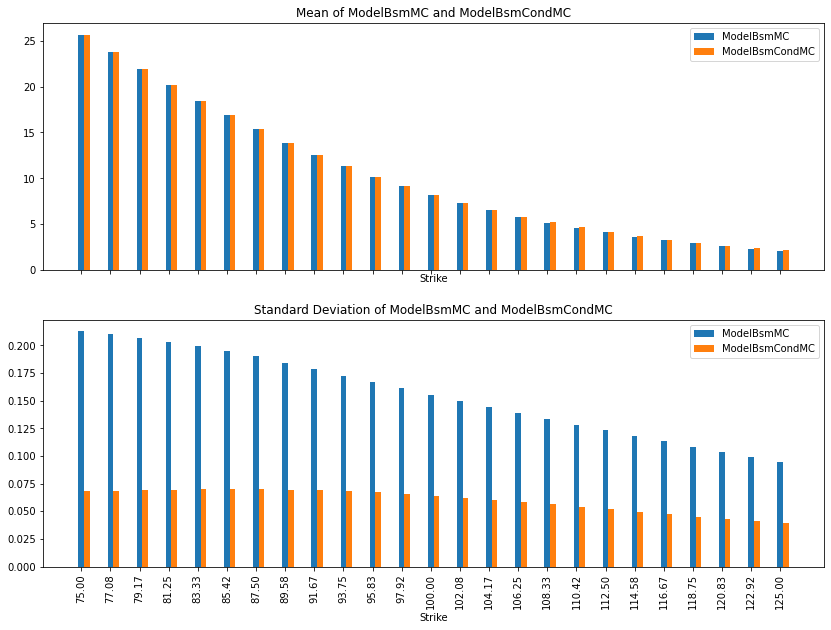

In [ ]:

mean_model_bsmmc = res1.mean(axis=0)
std_model_bsmmc = res1.std(axis=0)
mean_model_bsmcondmc = res2.mean(axis=0)
std_model_bsmcondmc = res2.std(axis=0)


len_strike = len
x = strike
total_width, n = 0.8, 2  
width = total_width / n
x1 = x - width / 2
x2 = x1 + width

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 10))
ax[0].bar(x1, mean_model_bsmmc, width=width, label='ModelBsmMC')
ax[0].bar(x2, mean_model_bsmcondmc, width=width, label='ModelBsmCondMC')
ax[0].legend()
ax[0].set_title('Mean of ModelBsmMC and ModelBsmCondMC')
ax[0].set_xticks(x)
ax[0].set_xticklabels(strike, rotation='vertical')
ax[0].set_xlabel('Strike')

ax[1].bar(x1, std_model_bsmmc, width=width, label='ModelBsmMC')
ax[1].bar(x2, std_model_bsmcondmc, width=width, label='ModelBsmCondMC')
ax[1].legend()
ax[1].set_title('Standard Deviation of ModelBsmMC and ModelBsmCondMC')
ax[1].set_xticks(x)
ax[1].set_xticklabels(strike, rotation='vertical')
ax[1].set_xlabel('Strike')

for axis in ax:
    axis.set_xticks(x1)
    axis.set_xticklabels([f'{i:.2f}' for i in strike], rotation='vertical')
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### <a id='toc1_4_2_'></a>[Comparison between ModelNormalMC and ModelNormalCondMC](#toc0_)

In [ ]:
print(sabr_norm.__dict__)
sabr_norm_mc = sabr.ModelNormalMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
sabr_norm_cmc = opt.sabr.ModelNormalCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
strike = np.linspace(75,125,num=25)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.25, 'beta': 0}


NameError: name 'opt' is not defined

In [ ]:
repeat = 100
len = strike.shape[0]
res3, res4 = np.ones((repeat, len)), np.ones((repeat, len))

for t in range(repeat):
    res3[t,:] = sabr_norm_mc.price(strike, forward, texp)

for t in range(repeat):
    res4[t,:] = sabr_norm_cmc.price(strike, forward, texp)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

mean_model_normalmc = res3.mean(axis=0)
std_model_normalmc = res3.std(axis=0)
mean_model_normalcondmc = res4.mean(axis=0)
std_model_normalcondmc = res4.std(axis=0)

len_strike = len
x = np.arange(len_strike)
total_width, n = 0.8, 2
width = total_width / n
x3 = strike - width / 2
x4 = x3 + width

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 10))
ax[0].bar(x3, mean_model_normalmc, width=width, label='ModelNormalMC')
ax[0].bar(x4, mean_model_normalcondmc, width=width, label='ModelNormalCondMC')
ax[0].legend()
ax[0].set_title('Mean of ModelNormalMC and ModelNormalCondMC')
ax[0].set_xlabel('Strike')

ax[1].bar(x3, std_model_normalmc, width=width, label='ModelNormalMC')
ax[1].bar(x4, std_model_normalcondmc, width=width, label='ModelNormalCondMC')
ax[1].legend()
ax[1].set_title('Standard Deviation of ModelNormalMC and ModelNormalCondMC')
ax[1].set_xlabel('Strike')

for axis in ax:
    axis.set_xticks(x3)
    axis.set_xticklabels([f'{i:.2f}' for i in strike], rotation='vertical')
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()


NameError: name 'res3' is not defined